In [ ]:
# pip install --upgrade category_encoders

     |████████████████████████████████| 82 kB 356 kB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.metrics import roc_curve, plot_roc_curve, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LinearRegression
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('energy_dataset.csv',parse_dates=['time'],index_col='time')
df.head(5)

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [ ]:
df.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35045 non-null  float64
 1   generation fossil brown coal/lignite         35046 non-null  float64
 2   generation fossil coal-derived gas           35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation fossil oil shale                  35046 non-null  float64
 7   generation fossil peat                       35046 non-null  float64
 8   generation geothermal                        35046 non-null  float64
 9   generation hydro pumped storage a

In [ ]:
df.corr()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
generation biomass,1.000000,0.229809,NaN,-0.021660,0.433522,0.459530,NaN,NaN,NaN,NaN,-0.044898,-0.284877,-0.033675,NaN,-0.021279,0.658488,-0.560588,-0.004687,-0.346343,NaN,-0.068658,-0.008713,NaN,-0.072368,0.085216,0.083288,0.108945,0.142369
generation fossil brown coal/lignite,0.229809,1.000000,NaN,0.499808,0.768710,0.314869,NaN,NaN,NaN,NaN,-0.323771,-0.525005,-0.229455,NaN,-0.008440,0.097600,0.104552,0.040447,0.282810,NaN,-0.434118,0.042306,NaN,-0.436031,0.278503,0.280461,0.567905,0.364088
generation fossil coal-derived gas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
generation fossil gas,-0.021660,0.499808,NaN,1.000000,0.541635,0.309623,NaN,NaN,NaN,NaN,-0.420646,-0.271527,0.060173,NaN,-0.112904,-0.066279,0.334880,0.074716,0.275053,NaN,-0.397298,0.080171,NaN,-0.397303,0.543711,0.548913,0.640895,0.461706
generation fossil hard coal,0.433522,0.768710,NaN,0.541635,1.000000,0.440837,NaN,NaN,NaN,NaN,-0.406116,-0.497940,-0.157677,NaN,-0.023930,0.264383,-0.019426,0.046185,0.170235,NaN,-0.441853,0.047356,NaN,-0.444490,0.394291,0.396564,0.671596,0.465641
generation fossil oil,0.459530,0.314869,NaN,0.309623,0.440837,1.000000,NaN,NaN,NaN,NaN,-0.331011,-0.106753,0.160465,NaN,0.015619,0.375046,-0.115087,0.100211,-0.175741,NaN,-0.051787,0.096435,NaN,-0.058244,0.498637,0.497089,0.292793,0.284679
generation fossil oil shale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
generation fossil peat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
generation geothermal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
generation hydro pumped storage aggregated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


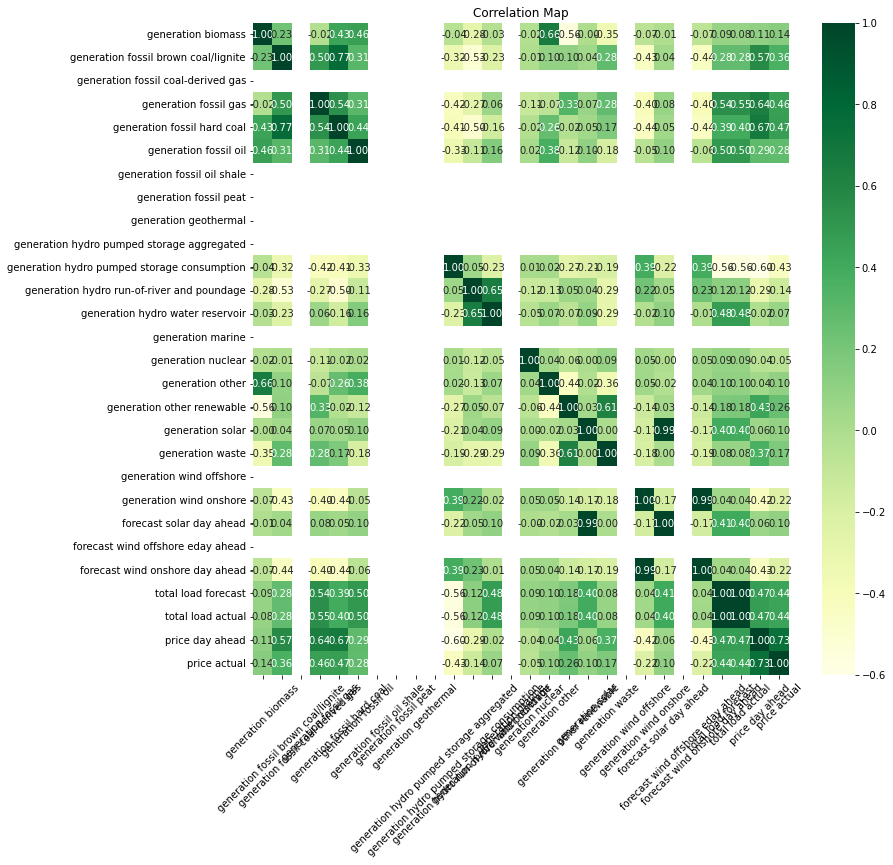

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), cmap='YlGn', annot=True, fmt = ".2f")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.show()

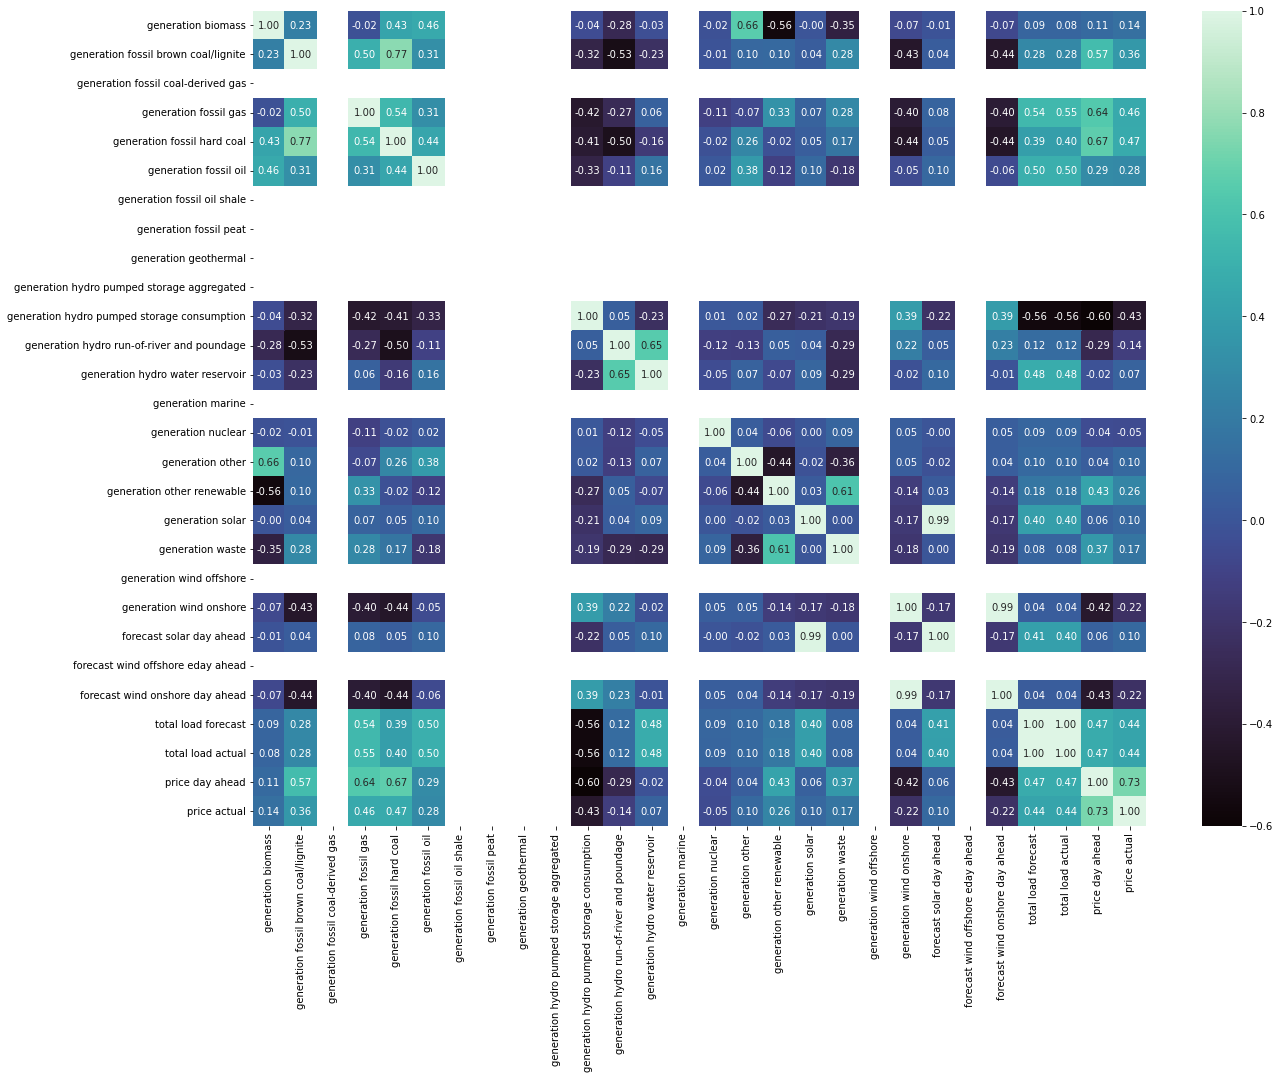

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), cmap='mako', annot=True, fmt="0.2f")

In [ ]:
# Rename columns by replacing all - or blank space with _
df.columns = df.columns.str.replace(' ','_').str.replace('-','_')
df.index = pd.to_datetime(df.index, utc=True)
df.drop(columns=['price_day_ahead',
                'generation_marine',
                'total_load_forecast',
                'generation_geothermal',
                'generation_fossil_peat',
                'generation_wind_offshore',
                'forecast_solar_day_ahead',
                'generation_fossil_oil_shale',
                'forecast_wind_onshore_day_ahead',
                'forecast_wind_offshore_eday_ahead',
                'generation_fossil_coal_derived_gas',
                'generation_hydro_pumped_storage_aggregated'],inplace=True)
df = df.drop(pd.Timestamp('2014-12-31 23:00:00+00:00')) 
df = df.sort_index()

# Season
condition_winter = (df.index.month>=1)&(df.index.month<=3)
condtion_spring = (df.index.month>=4)&(df.index.month<=6)
condition_summer = (df.index.month>=7)&(df.index.month<=9)
condition_automn = (df.index.month>=10)@(df.index.month<=12)

df['season'] = np.where(condition_winter,'winter', np.where(condtion_spring,'spring', np.where(condition_summer,'summer', np.where(condition_automn,'automn',np.nan))))

In [ ]:
# Price per total load
fig = px.scatter(df,x='total_load_actual', y='price_actual', facet_col='season', opacity=0.1, title='Price Per KW Hour/Total Energy Genereated Per Season', animation_frame=df.index.year)

# Figure customizations
fig.update_traces(marker=dict(size=12, line=dict(width=2, color='darkslateblue')), selector=dict(mode='markers'))

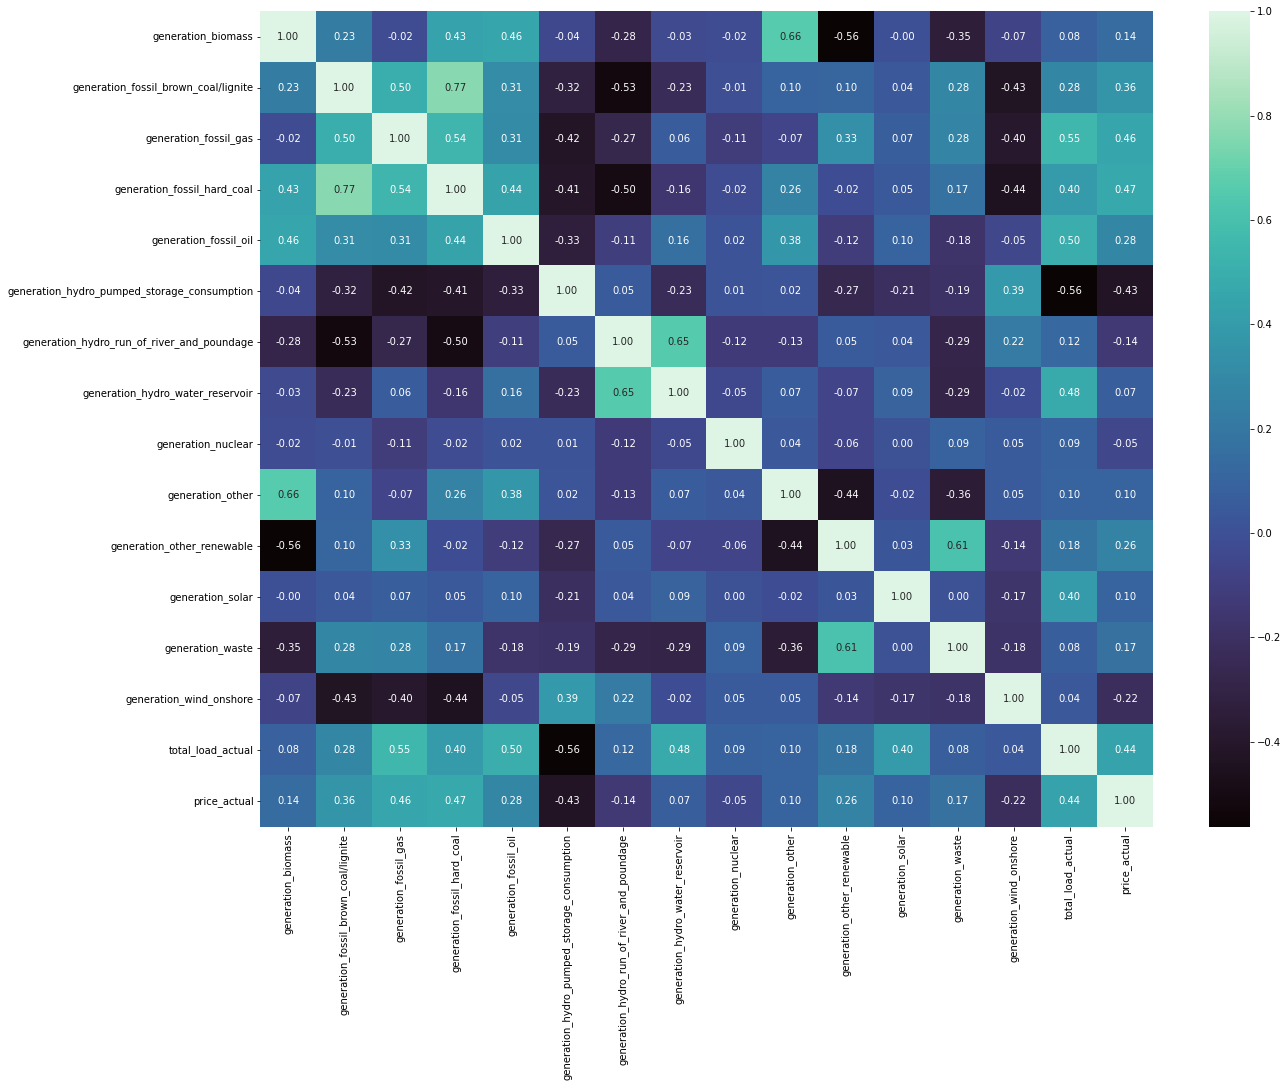

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), cmap='mako', annot=True, fmt="0.2f")

In [ ]:
df.corr()

,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_onshore,total_load_actual,price_actual
generation_biomass,1.000000,0.229819,-0.021652,0.433520,0.459633,-0.044909,-0.284884,-0.033667,-0.021300,0.658518,-0.560580,-0.004669,-0.346325,-0.068665,0.083304,0.142360
generation_fossil_brown_coal/lignite,0.229819,1.000000,0.499806,0.768715,0.314875,-0.323768,-0.525004,-0.229459,-0.008430,0.097593,0.104545,0.040440,0.282805,-0.434116,0.280457,0.364095
generation_fossil_gas,-0.021652,0.499806,1.000000,0.541640,0.309627,-0.420643,-0.271526,0.060169,-0.112895,-0.066289,0.334876,0.074709,0.275047,-0.397296,0.548911,0.461714
generation_fossil_hard_coal,0.433520,0.768715,0.541640,1.000000,0.440901,-0.406122,-0.497942,-0.157675,-0.023939,0.264393,-0.019419,0.046192,0.170252,-0.441857,0.396573,0.465639
generation_fossil_oil,0.459633,0.314875,0.309627,0.440901,1.000000,-0.331007,-0.106748,0.160452,0.015694,0.375023,-0.115166,0.100160,-0.175872,-0.051771,0.497086,0.284747
generation_hydro_pumped_storage_consumption,-0.044909,-0.323768,-0.420643,-0.406122,-0.331007,1.000000,0.053161,-0.234337,0.013067,0.021521,-0.267431,-0.214638,-0.188087,0.389051,-0.562805,-0.426428
generation_hydro_run_of_river_and_poundage,-0.284884,-0.525004,-0.271526,-0.497942,-0.106748,0.053161,1.000000,0.652772,-0.124052,-0.127336,0.053441,0.039607,-0.286102,0.223156,0.118575,-0.137110
generation_hydro_water_reservoir,-0.033667,-0.229459,0.060169,-0.157675,0.160452,-0.234337,0.652772,1.000000,-0.049548,0.065091,-0.065748,0.091826,-0.288285,-0.019228,0.479477,0.071555
generation_nuclear,-0.021300,-0.008430,-0.112895,-0.023939,0.015694,0.013067,-0.124052,-0.049548,1.000000,0.041180,-0.062500,0.004411,0.086668,0.049159,0.085686,-0.052612
generation_other,0.658518,0.097593,-0.066289,0.264393,0.375023,0.021521,-0.127336,0.065091,0.041180,1.000000,-0.443763,-0.016582,-0.360642,0.047725,0.100675,0.100063


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35063 entries, 2015-01-01 00:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           35044 non-null  float64
 1   generation_fossil_brown_coal/lignite         35045 non-null  float64
 2   generation_fossil_gas                        35045 non-null  float64
 3   generation_fossil_hard_coal                  35045 non-null  float64
 4   generation_fossil_oil                        35044 non-null  float64
 5   generation_hydro_pumped_storage_consumption  35044 non-null  float64
 6   generation_hydro_run_of_river_and_poundage   35044 non-null  float64
 7   generation_hydro_water_reservoir             35045 non-null  float64
 8   generation_nuclear                           35046 non-null  float64
 9   generation_other         

## **MODELS: RIDGE + LINEARREGRESSION **

In [ ]:
target='price_actual'

# Split data
y, X = df[target],df.drop(columns=target)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.2,random_state=42)

In [ ]:
# Assign variables for baselines and calculate baselines
y_pred = [y_train.mean()]*len(y_train)
mean_baseline_pred = y_train.mean()
baseline_mae = mean_absolute_error(y_train,y_pred)
baseline_rmse = mean_squared_error(y_train,y_pred,squared=False)

# Print statement to show all baseline values
print('Mean Price Per KW/h Baseline Pred:', mean_baseline_pred)
print('-------------------------------------------------------------------')
print('Baseline Mae:',baseline_mae)
print('-------------------------------------------------------------------')
print('Baseline RMSE:',baseline_rmse)

Mean Price Per KW/h Baseline Pred: 57.92005454545454
-------------------------------------------------------------------
Baseline Mae: 11.08589652244369
-------------------------------------------------------------------
Baseline RMSE: 14.21051579246629


In [ ]:
# One Hot Encoder for Seasons
onehot = OneHotEncoder(use_cat_names=True)
onehot_fit = onehot.fit(X_train)
XT_train = onehot.transform(X_train)
XT_val = onehot.transform(X_val)

# Deal with NaN Values
simp = SimpleImputer(strategy='mean')
simp_fit = simp.fit(XT_train)
XT_train = simp.transform(XT_train)
XT_val = simp.transform(XT_val)

model_lr=LinearRegression()
model_r=Ridge()

model_r.fit(XT_train,y_train);
model_lr.fit(XT_train,y_train);

In [ ]:
def check_metrics(model):
    print(model)
    print('===================================================================')
    print('Training MAE:', mean_absolute_error(y_train,model.predict(XT_train)))
    print('-------------------------------------------------------------------')
    print('Validation MAE:', mean_absolute_error(y_val,model.predict(XT_val)))
    print('-------------------------------------------------------------------')
    print('Validation R2 score:', model.score(XT_val,y_val))
    print('-------------------------------------------------------------------')
    print('MAPE score:', np.mean(np.abs((y_train - model.predict(XT_train)) / y_train)) * 100)
    print('===================================================================')


In [ ]:
model = [model_r,model_lr]
for m in model:
  check_metrics(m)

Ridge()
Training MAE: 8.064800345014538
-------------------------------------------------------------------
Validation MAE: 8.12846909947165
-------------------------------------------------------------------
Validation R2 score: 0.4265774820282501
-------------------------------------------------------------------
MAPE score: 16.870339436714715
LinearRegression()
Training MAE: 8.064818613080801
-------------------------------------------------------------------
Validation MAE: 8.12846659640155
-------------------------------------------------------------------
Validation R2 score: 0.4265793720525829
-------------------------------------------------------------------
MAPE score: 16.87030644056988


## **DATA PREPARATION + TEST METRICS**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df1 = pd.read_csv('energy_dataset.csv')

In [ ]:
dataset = df1['total load actual'].dropna().values

In [ ]:
dataset = dataset.astype('float32') 
# Reshape to one feature (Because ''required by The model'')
dataset = np.reshape(dataset, (-1, 1))

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1)) # Min Max scaler
dataset = scaler.fit_transform(dataset) # fit and transform the dataset

# Train and Test splits
train_size = int(len(dataset) * 0.80) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
def test_metrics():
    print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
    print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))
    print("Testing MAPE: {}".format(mape))
    

In [ ]:
def pred_plot():
  idx = 200
  aa=[x for x in range(idx)]
  plt.figure(figsize=(8,4))
  plt.plot(aa, Y_test[:idx], marker='.', label="actual")
  plt.plot(aa, test_predict[:idx], 'r', label="prediction")
  # plt.tick_params(left=False, labelleft=True) #remove ticks
  plt.tight_layout()
  sns.despine(top=True)
  plt.subplots_adjust(left=0.07)
  plt.ylabel('TOTAL Load', size=15)
  plt.xlabel('Time step', size=15)
  plt.legend(fontsize=15)
  plt.show();

## **ARIMA**

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=False)

In [ ]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100

In [ ]:
test_metrics()

Test Mean Absolute Error: 10816.588586802704
Test Root Mean Squared Error: 11722.243281176989
Testing MAPE: 35.88114050416548


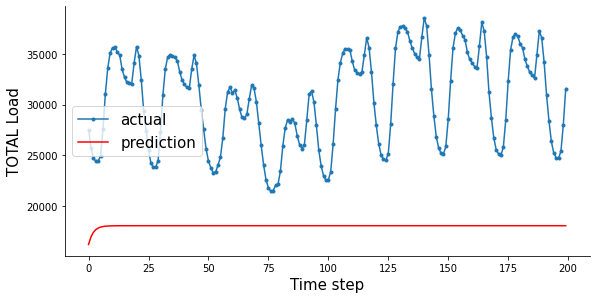

In [ ]:
pred_plot()

## **ARMA**

In [ ]:
from statsmodels.tsa.arima_model import ARMA

In [ ]:
model = ARMA(train, order=(2, 1))
model_fit = model.fit(disp=False)

In [ ]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100

In [ ]:
test_metrics()

Test Mean Absolute Error: 3862.929069305042
Test Root Mean Squared Error: 4521.711388568003
Testing MAPE: 13.815134121438518


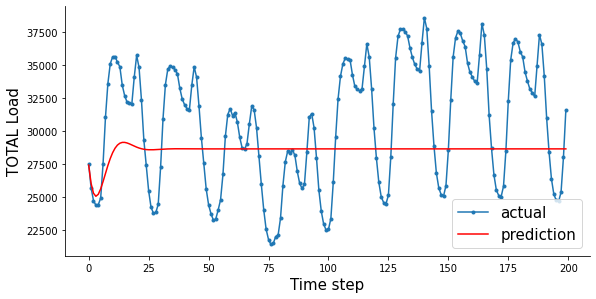

In [ ]:
pred_plot()

### **LSTM**

In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
look_back = 25
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=200, batch_size=70, validation_data=(X_test, Y_test),verbose=1, shuffle=False)

model.summary()

Epoch 1/200
400/400 [==============================] - 12s 17ms/step - loss: 0.0151 - val_loss: 0.0036
Epoch 2/200
400/400 [==============================] - 7s 16ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 3/200
400/400 [==============================] - 7s 16ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 4/200
400/400 [==============================] - 6s 16ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 5/200
400/400 [==============================] - 7s 16ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 6/200
400/400 [==============================] - 7s 16ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 7/200
400/400 [==============================] - 7s 17ms/step - loss: 0.0018 - val_loss: 9.7698e-04
Epoch 8/200
400/400 [==============================] - 7s 16ms/step - loss: 0.0017 - val_loss: 9.4717e-04
Epoch 9/200
400/400 [==============================] - 7s 17ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 10/200
400/400 [==============================] - 6s 16ms/step - lo

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [ ]:
mape_train = np.mean(np.abs((Y_train[0] - train_predict[:,0]) / Y_train[0])) * 100
mape_test = np.mean(np.abs((Y_test[0] - test_predict[:,0]) / Y_test[0])) * 100

print("Train MAPE: {}, Test MAPE: {}".format(mape_train, mape_test))

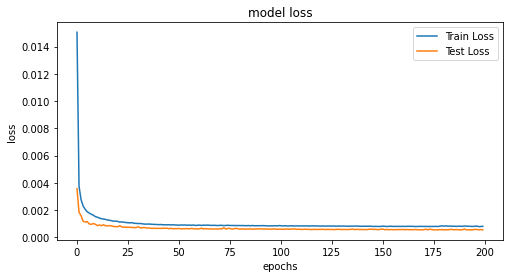

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

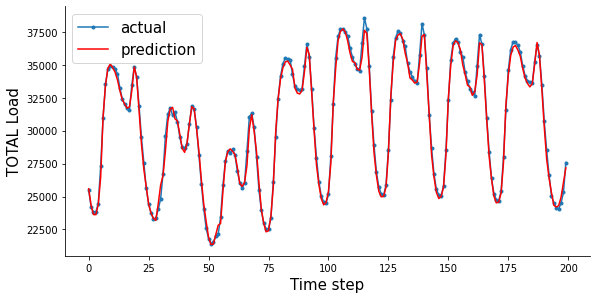

In [ ]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();